In [59]:
import scipy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Spin
from pprint import pprint
from dimod import ExactSolver

#myqlm imports
from qat.lang.AQASM import *
from qat.lang.AQASM import *
from qat.qpus import get_default_qpu
import import_ipynb
import ipynb

from QAOAutils import SolverQAOA

# Quantum Approximate Optimization Algorithm (QAOA)

O QAOA é uma heurística desenvolvida por Edward Farhi (https://arxiv.org/abs/1411.4028), especialmente para resolver problemas de otimização combinatória. Sua arquitetura híbrida é projetada de forma que um computador clássico seja utilizado para otimizar parâmetros de um circuito quântico, a fim de se otimizar uma função objetivo calculada a partir de medidas no computador quântico.

    - Material de referência: Aula QAOA

Neste notebook tutorial, vamos utilizar o QAOA para minimizar uma função de variáveis binárias e poderá ser generalizado para outros problemas ao longo do curso. A função que vamos utilizar como exemplo é dada por

$$H(\vec{x}) = x_0x_2 -2x_1x_0 + 5x_3x_1$$

onde $x_i \in \{0,1\}$. Contudo, vimos nas aulas anteriores que devemos utilizar variáveis de spin $z_i$, tal que $z_i \in \{-1, +1\}$, para que seja possível codificar a função objetivo em um circuito quântico de forma fácil. Para isso, realizaremos a transformação $x_i = \frac{z_i + 1}{2}$. Dessa forma, podemos escrever $H$ em função das variáveis de spin, ou seja, $H(\vec{z})$.

#### Utilizando o pacote `PyQubo` para criar o QUBO:

In [60]:
h =( Binary("x0")*Binary("x2") - 2*Binary("x1")*Binary("x0") + 5*Binary("x3")*Binary("x1") )
model = h.compile()

#Note que o método phase_op(), da classe SolverQAOA, já implementa a 
#transformação de variáveis através da função to_ising(), do PyQubo.


### Operador de Fase

Para que seja possível codificar a função objetivo $H(\vec{z})$ em um circuito quântico, faremos a transformação $z_i \rightarrow Z_i$, onde $Z_i$ é a operação de Pauli-Z - cujos autovalores são $-1$ ou $+1$ - atuando no qubit $i$. Dessa forma, podemos reescrever o problema através de um hamiltoniano de Ising, dado de forma genérica por

$$H(\vec{Z}) = - \sum_{i=0}^{n}h_iZ_i - \sum_{<ij>}J_{ij}Z_iZ_j$$

Entretanto, $H(\vec{Z})$ não é um operador unitário e, portanto, não pode ser implementado no circuito quântico. Um truque para transformá-lo em um operador unitário é através de uma exponenciação matricial. Introduziremos na exponenciação o parâmetro variacional, $\gamma$, chegando na seguinte operação:

$$U(\gamma) = e^{-i\gamma H(\vec{Z})}$$

Sugerimos que os alunos trabalhem um pouco com essas expressões de forma manual para adquirir familiaridade com a matemática por trás da exponenciação matricial. Dica: para chegar na forma matricial de $U(\gamma)$, utilize a expansão $e^x = \sum_{k} \frac{x^k}{k!}$ e perceba o padrão dos resultados para matrizes diagonais.

### Instanciando o objeto SolverQAOA

Para fins didáticos, instaciaremos o SolverQAOA, utilizando como argumentos: o modelo criado anteriormente; o número de variáveis; o número de medidas no circuito quântico; e a profundidade do circuito;

In [61]:
qaoa_myqlm = SolverQAOA(binary_model = model, num_variables = 4, num_measurements=10, depth=1)

In [62]:
phase_circuit = qaoa_myqlm.phase_op(gamma = np.pi)

%qatdisplay phase_circuit --svg

Note que as operações controladas implementam os termos quadráticos do hamiltoniano de Ising, enquanto as operações de qubits individuais, representam os termos lineares.

### Operador de Mistura

Este operador é responsável por criar interferências nas amplitudes de probabilidades, realizando as variações no espaço de busca. Podemos implementá-lo simplesmente através do operador

$$U(\beta) = \bigotimes_{i=0}^{n} RX(2\beta)$$

Contudo, há outros operadores que podem ser mais eficientes. Novamente, para fins didáticos, utilizaremos a implementação mais simples.

In [63]:
mix_circuit = qaoa_myqlm.mixer_op(beta = np.pi)
%qatdisplay mix_circuit --svg

### Camadas do QAOA

A aplicação dos dois operadores $U(\beta)U(\gamma) \equiv U(\gamma, \beta)$, sobre um estado inicial dado por $H^{\otimes n}|0\rangle^{\otimes n} = |\psi\rangle$, é dada por $U(\gamma, \beta)|\psi\rangle = |\gamma, \beta\rangle $.

Portanto, a aplicação de múltiplas camadas resulta no estado dado por

$$U(\vec{\gamma}, \vec{\beta})|\psi\rangle = |\vec{\gamma}, \vec{\beta}\rangle$$

Note que $|\gamma, \beta\rangle$ representa as amplitudes de probabilidade do estado medido. 

In [64]:
# camada única do QAOA e medidas para chute inicial de gamma e beta
initial_guess = [np.pi/3, np.pi]
full_circ, initial_meas = qaoa_myqlm.full_circuit_measurements(initial_guess)
%qatdisplay full_circ --svg

<BarContainer object of 9 artists>

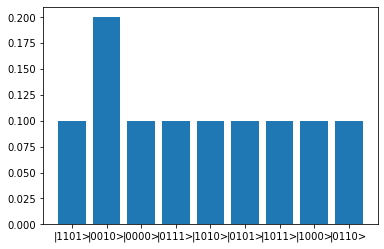

In [65]:
states=[]; probs = []
for key, value in initial_meas.items():
    states.append(str(key))
    probs.append(value)

plt.bar(states, probs)


### Valor esperado do Hamiltoniano

O valor esperado do hamiltoniano de Ising (ou energia média), que representa a função a ser minimizada, pode ser dado, na notação de Dirac por

$$F(\vec{\gamma}, \vec{\beta}) = \langle \vec{\gamma}, \vec{\beta}| H(\vec{Z}) | \vec{\gamma}, \vec{\beta} \rangle $$

A expressão acima também pode ser escrita como a média ponderada das energias das combinações medidas, o que facilita o entendimento de como o QAOA pode ser resolvido numericamente. Logo, reescrevemos a função objetivo (valor esperado) como

$$F(\vec{\gamma}, \vec{\beta}) = \sum_{i=0}^{\text{poly}(n)} E_ip_i.$$

As energias $E_i$ e as probabilidades $p_i$ estão associadas aos seus respectivos autoestados $|i\rangle$. A ordem do somatório, $\text{poly}(n)$, indica que devemos realizar um número polinomial de medidas no circuito.

In [66]:
# cada energia relacionada a um autoestado
# exemplo:
energy_0101 = qaoa_myqlm.cost_function('0101')
print("Energia associada ao autoestado |0101>:  ", energy_0101, "\n",50*"#")

# valor esperado de energia <psi|H|psi> para os chutes iniciais:
exp_val = qaoa_myqlm.expected_value(initial_guess)
print(" \n \n Valor esperado de energia para o chute inicial:  ", exp_val, "\n",50*"#")

Energia associada ao autoestado |0101>:   5.0 
 ##################################################
 
 
 Valor esperado de energia para o chute inicial:   0.0 
 ##################################################


### Otimização do circuito

Nesta etapa final, utilizaremos métodos clássicos de otimização para atualizar corretamente os parâmetros $\vec{\gamma}$ e $\vec{\beta}$ para minimizar o valor esperado. Para isso, instanciaremos novamente um objeto SolverQAOA com novos argumentos e utilizaremos o método run() para encontrar o ótimo aproximado pelo QAOA.

In [67]:
# instanciando o SolverQAOA
qaoa = SolverQAOA(binary_model = model, num_variables = 4, num_measurements=1000, depth=4)

In [68]:
# ins
res = qaoa.run()


 
 QAOA solution:  |1100>
Pyqubo solution:  {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0}


#### Exercício:

Modifique valores como `num_measurements`, `depth`, bem como o próprio QUBO (e seu `num_variables`) para realizar testes e testar a performance do QAOA. Tenha em mente que os autores demonstraram que a razão de aproximação do algoritmo é de $~0.69$ para um número de camadas $p=1$. Abaixo, há algumas referencias sobre o QAOA e sua performance. Com isso em mãos, veja se seus experimentos condizem com os resultados encontrados, ainda que para instancias pequenas. Um trabalho interessante após ou durante esse curso, seria criar um documento reportando os experimentos em diferentes cenários.